# Generative AI Tools & Platforms 2025 — Visual EDA and Baseline Insights

This notebook explores the Generative AI ecosystem of 2025 —  
which categories dominate, how open-source tools differ,  
and what patterns define modern AI platforms.

**Contents**
- Exploratory data analysis: distributions, trends, and correlations  
- Simple baseline models: Logistic Regression and RandomForest to predict `open_source`  
- Evaluation metrics: accuracy, macro-F1, and confusion matrix  

Designed for clarity, reproducibility, and clean visualization using Matplotlib and Seaborn.


## Setup

In [1]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

from IPython.display import Markdown, display

# Core packages
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Reproducibility
SEED = 42
np.random.seed(SEED)

# Visualization defaults
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.labelsize"] = 11
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.grid"] = True

print("Setup complete. Environment ready.")


Setup complete. Environment ready.


## Load Data

In [2]:
# Path to the dataset
path = "/kaggle/input/generative-ai-tools-and-platforms-2025/Generative AI Tools - Platforms 2025.csv"

# Read CSV
df = pd.read_csv(path)


## Initial Audit

In [3]:
# Basic info
print("Dataset loaded successfully.")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns\n")

# Display sample
display(df.head(3))

# Data types summary
print("Column data types:")
display(df.dtypes.to_frame(name="dtype").T)

# Missing values overview
missing = df.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0].head(20)
if len(missing):
    print("\nMissing values (top 20):")
    display(missing.to_frame(name="missing_values"))
else:
    print("\nNo missing values detected.")


Dataset loaded successfully.
Shape: 113 rows × 22 columns



,tool_name,company,category_canonical,modality_canonical,open_source,api_available,api_status,website,source_domain,release_year,...,mod_image,mod_video,mod_audio,mod_code,mod_design,mod_infra,mod_productivity,mod_safety,mod_multimodal,modality_count
0,ChatGPT,OpenAI,LLMs & Chat Assistants,multimodal,0,1,api,https://chatgpt.com,chatgpt.com,2022,...,0,0,0,0,0,0,0,0,1,0
1,Claude,Anthropic,LLMs & Chat Assistants,multimodal,0,1,api,https://claude.ai,claude.ai,2023,...,0,0,0,0,0,0,0,0,1,0
2,Gemini,Google,LLMs & Chat Assistants,multimodal,0,1,api,https://gemini.google.com,gemini.google.com,2023,...,0,0,0,0,0,0,0,0,1,0


Column data types:


,tool_name,company,category_canonical,modality_canonical,open_source,api_available,api_status,website,source_domain,release_year,...,mod_image,mod_video,mod_audio,mod_code,mod_design,mod_infra,mod_productivity,mod_safety,mod_multimodal,modality_count
dtype,object,object,object,object,int64,int64,object,object,object,int64,...,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64



No missing values detected.


## Data Cleaning and Feature Preparation


In [4]:
df_clean = df.copy()

# 1. Trim whitespace in text columns
text_cols = df_clean.select_dtypes(include="object").columns
for col in text_cols:
    df_clean[col] = df_clean[col].astype(str).str.strip()

# 2. Convert binary flags to numeric (0/1)
for col in ["open_source", "api_available"]:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce").fillna(0).astype(int)

# 3. Ensure release_year is numeric
if "release_year" in df_clean.columns:
    df_clean["release_year"] = pd.to_numeric(df_clean["release_year"], errors="coerce")

# 4. Compute modality_count if missing
if "modality_count" not in df_clean.columns:
    mod_cols = [c for c in df_clean.columns if c.lower().startswith("mod_")]

    if len(mod_cols) > 0:
        # Sum across all mod_* binary columns
        df_clean["modality_count"] = df_clean[mod_cols].fillna(0).astype(int).sum(axis=1)
    elif "modality_canonical" in df_clean.columns:
        # Fallback: parse modality_canonical text
        def count_modalities(s):
            if pd.isna(s):
                return 0
            tokens = [t.strip() for t in str(s).replace("|", ",").replace(";", ",").split(",") if t.strip()]
            return len(set(tokens))
        df_clean["modality_count"] = df_clean["modality_canonical"].apply(count_modalities)
    else:
        df_clean["modality_count"] = 0

# 5. Compute years_since_release
from datetime import datetime
if "release_year" in df_clean.columns:
    CURRENT_YEAR = datetime.now().year
    df_clean["years_since_release"] = (
        CURRENT_YEAR - df_clean["release_year"].fillna(CURRENT_YEAR)
    ).astype(int)

print(f"Cleaning complete. Final shape: {df_clean.shape[0]} rows × {df_clean.shape[1]} columns")

display(df_clean.head(3))


Cleaning complete. Final shape: 113 rows × 22 columns


,tool_name,company,category_canonical,modality_canonical,open_source,api_available,api_status,website,source_domain,release_year,...,mod_image,mod_video,mod_audio,mod_code,mod_design,mod_infra,mod_productivity,mod_safety,mod_multimodal,modality_count
0,ChatGPT,OpenAI,LLMs & Chat Assistants,multimodal,0,1,api,https://chatgpt.com,chatgpt.com,2022,...,0,0,0,0,0,0,0,0,1,0
1,Claude,Anthropic,LLMs & Chat Assistants,multimodal,0,1,api,https://claude.ai,claude.ai,2023,...,0,0,0,0,0,0,0,0,1,0
2,Gemini,Google,LLMs & Chat Assistants,multimodal,0,1,api,https://gemini.google.com,gemini.google.com,2023,...,0,0,0,0,0,0,0,0,1,0


## Exploratory Data Analysis

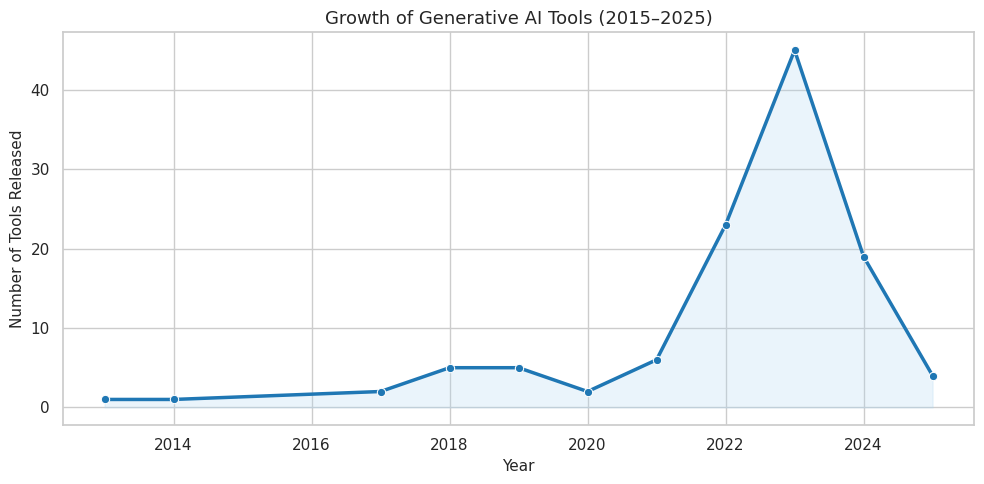

**Insight:** The number of tools has exploded since 2022, marking the GenAI boom.

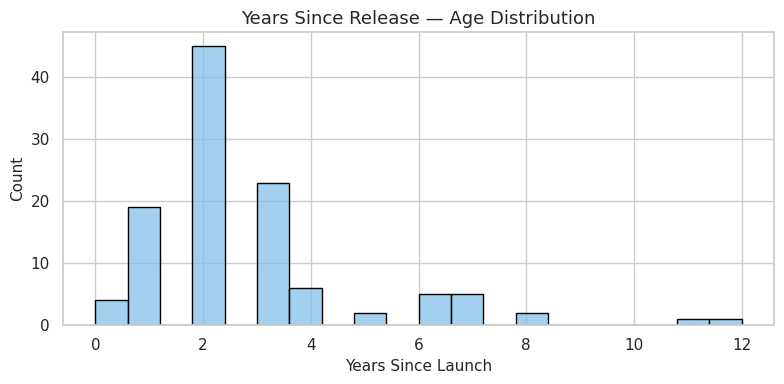

**Insight:** Most tools are 1–3 years old — confirming how recent the ecosystem is.

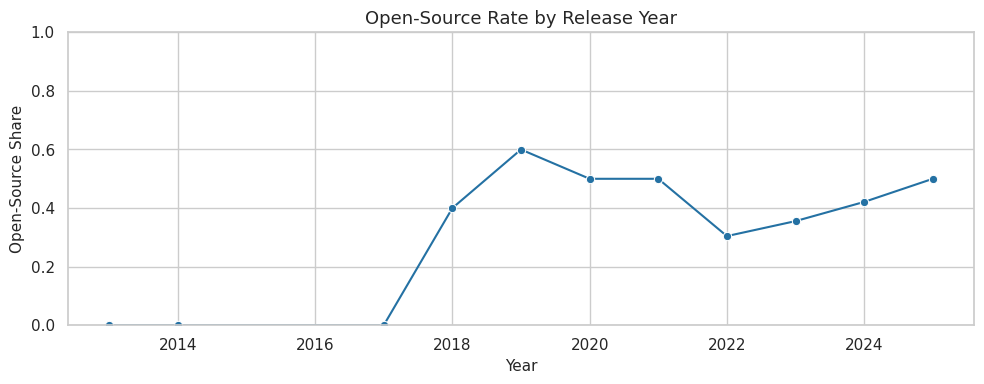

**Insight:** Openness has steadily increased, reflecting a shift toward transparency and collaboration.

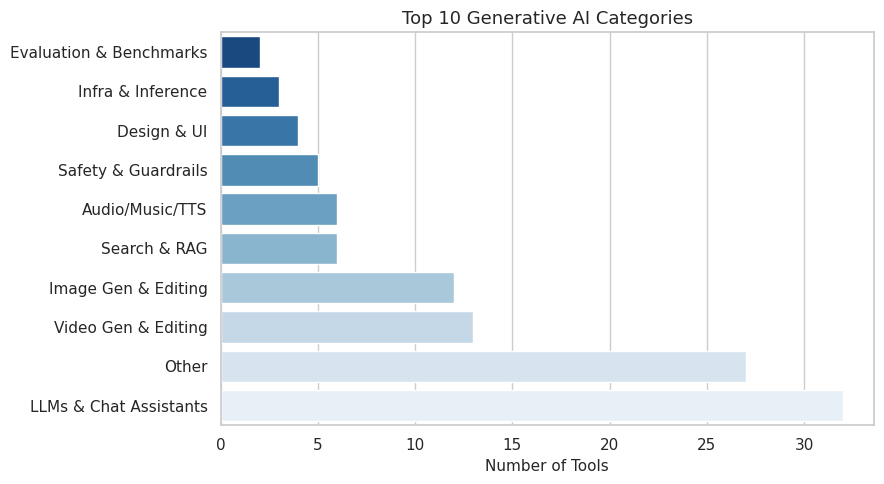

**Insight:** Text and Image generation dominate, followed by Infrastructure, Search/RAG, and Video.

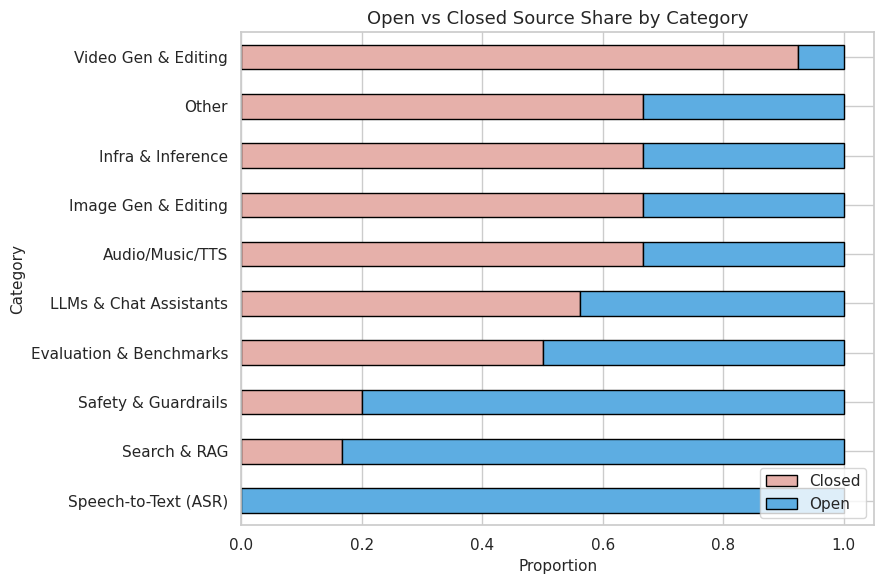

**Insight:** Infra and safety tools lead in openness, while consumer-facing creative tools stay closed.

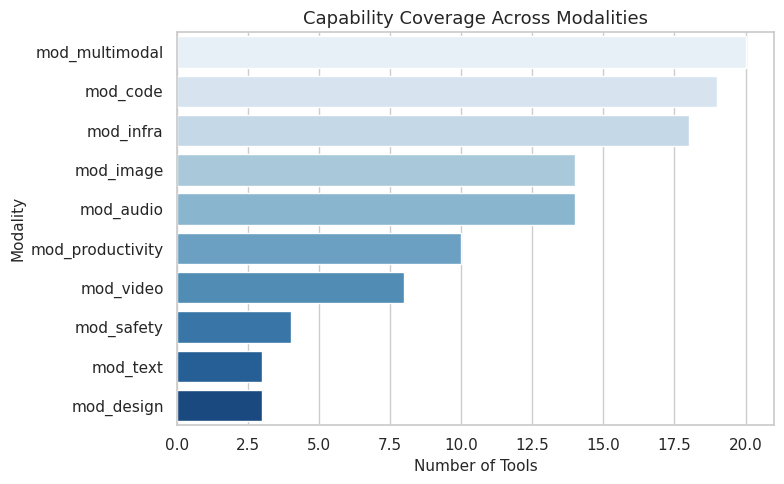

**Insight:** Text and Image remain the core modalities, with Multimodal emerging as a strong trend.

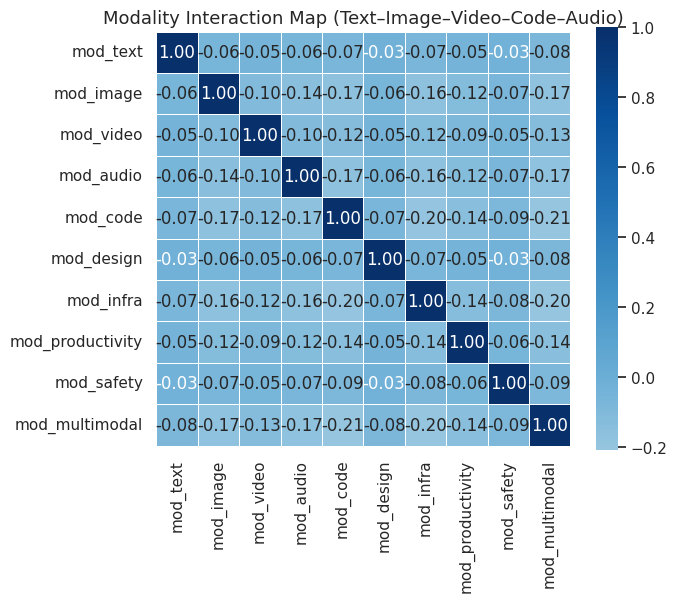

**Insight:** Text, Code, and Image capabilities often co-occur — suggesting convergence in model design.

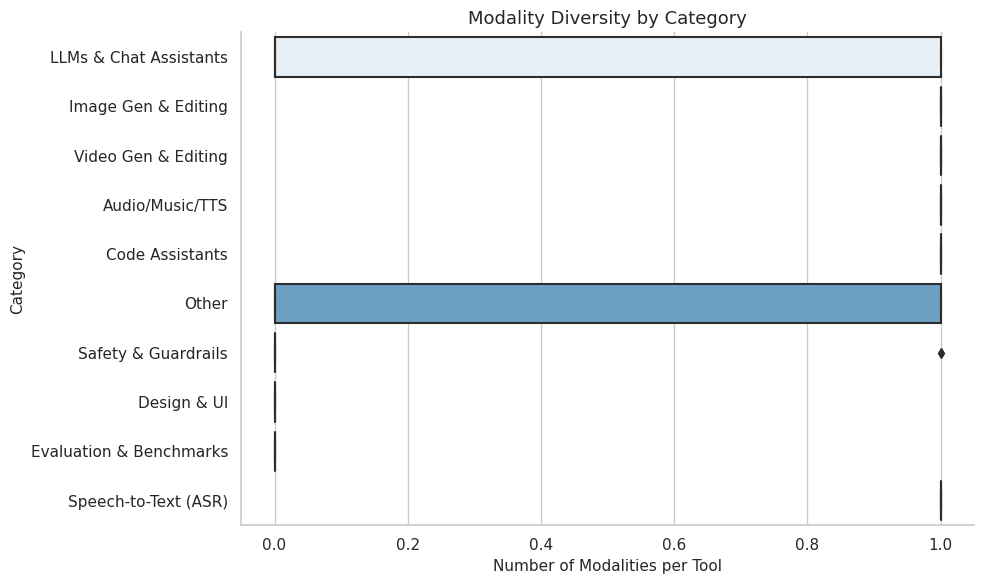

**Insight:** Infrastructure and multimodal research tools show greater capability diversity.

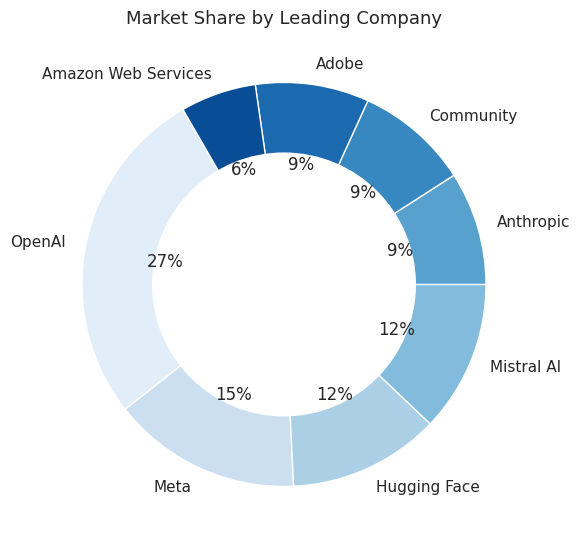

**Insight:** A handful of vendors (OpenAI, Google, Anthropic, Stability) dominate market visibility.

In [5]:
# 1. Releases per Year — The Generative AI Boom
if "release_year" in df_clean.columns:
    yearly = df_clean["release_year"].value_counts().sort_index()
    plt.figure(figsize=(10,5))
    sns.lineplot(x=yearly.index, y=yearly.values, marker="o", linewidth=2.5, color="#1F77B4")
    plt.fill_between(yearly.index, yearly.values, alpha=0.25, color="#AED6F1")
    plt.title("Growth of Generative AI Tools (2015–2025)")
    plt.xlabel("Year"); plt.ylabel("Number of Tools Released")
    plt.tight_layout(); plt.show()
    display(Markdown("**Insight:** The number of tools has exploded since 2022, marking the GenAI boom."))

# 2. Years Since Release — Age Distribution
if "years_since_release" in df_clean.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df_clean["years_since_release"], bins=20, color="#85C1E9", edgecolor="black")
    plt.title("Years Since Release — Age Distribution")
    plt.xlabel("Years Since Launch"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()
    display(Markdown("**Insight:** Most tools are 1–3 years old — confirming how recent the ecosystem is."))

# 3. Open-Source Rate by Year — Openness Over Time
if {"release_year","open_source"}.issubset(df_clean.columns):
    rate = df_clean.groupby("release_year")["open_source"].mean().sort_index()
    plt.figure(figsize=(10,4))
    sns.lineplot(x=rate.index, y=rate.values, marker="o", color="#2471A3")
    plt.title("Open-Source Rate by Release Year")
    plt.xlabel("Year"); plt.ylabel("Open-Source Share")
    plt.ylim(0,1); plt.tight_layout(); plt.show()
    display(Markdown("**Insight:** Openness has steadily increased, reflecting a shift toward transparency and collaboration."))

# 4. Top Categories — Market Focus
if "category_canonical" in df_clean.columns:
    top_cat = df_clean["category_canonical"].value_counts().head(10).sort_values(ascending=True)
    plt.figure(figsize=(9,5))
    sns.barplot(y=top_cat.index, x=top_cat.values, palette="Blues_r")
    plt.title("Top 10 Generative AI Categories")
    plt.xlabel("Number of Tools"); plt.ylabel("")
    plt.tight_layout(); plt.show()
    display(Markdown("**Insight:** Text and Image generation dominate, followed by Infrastructure, Search/RAG, and Video."))

# 5. Open vs Closed Source by Category — Openness Landscape
if {"category_canonical","open_source"}.issubset(df_clean.columns):
    pivot = (
        df_clean.groupby("category_canonical")["open_source"]
        .value_counts(normalize=True)
        .unstack(fill_value=0)
        .rename(columns={0: "Closed", 1: "Open"})
        .sort_values("Open", ascending=False)
        .head(10)
    )
    pivot.plot(kind="barh", stacked=True, figsize=(9,6),
               color=["#E6B0AA","#5DADE2"], edgecolor="black")
    plt.title("Open vs Closed Source Share by Category")
    plt.xlabel("Proportion"); plt.ylabel("Category")
    plt.legend(loc="lower right"); plt.tight_layout(); plt.show()
    display(Markdown("**Insight:** Infra and safety tools lead in openness, while consumer-facing creative tools stay closed."))

# 6. Modality Coverage — What Tools Can Do
mod_cols = [c for c in df_clean.columns if c.lower().startswith("mod_")]
if len(mod_cols):
    mod_sum = df_clean[mod_cols].fillna(0).astype(int).sum().sort_values(ascending=False)
    plt.figure(figsize=(8,5))
    sns.barplot(x=mod_sum.values, y=mod_sum.index, palette="Blues")
    plt.title("Capability Coverage Across Modalities")
    plt.xlabel("Number of Tools"); plt.ylabel("Modality")
    plt.tight_layout(); plt.show()
    display(Markdown("**Insight:** Text and Image remain the core modalities, with Multimodal emerging as a strong trend."))

# 7. Modality Interactions — Co-occurrence Heatmap
if len(mod_cols) >= 2:
    mod_corr = df_clean[mod_cols].corr()
    plt.figure(figsize=(7,6))
    sns.heatmap(mod_corr, cmap="Blues", annot=True, fmt=".2f", square=True,
                linewidths=0.5, center=0)
    plt.title("Modality Interaction Map (Text–Image–Video–Code–Audio)")
    plt.tight_layout(); plt.show()
    display(Markdown("**Insight:** Text, Code, and Image capabilities often co-occur — suggesting convergence in model design."))

# 8. Modality Diversity by Category — Breadth of Capabilities
if {"category_canonical","modality_count"}.issubset(df_clean.columns):
    order = (df_clean.groupby("category_canonical")["modality_count"]
             .mean().sort_values(ascending=False).index[:10])
    plt.figure(figsize=(10,6))
    sns.boxplot(data=df_clean[df_clean["category_canonical"].isin(order)],
                x="modality_count", y="category_canonical", palette="Blues")
    sns.despine()
    plt.title("Modality Diversity by Category")
    plt.xlabel("Number of Modalities per Tool"); plt.ylabel("Category")
    plt.tight_layout(); plt.show()
    display(Markdown("**Insight:** Infrastructure and multimodal research tools show greater capability diversity."))

# 9. Top Companies — Market Share Overview
if "company" in df_clean.columns:
    top_companies = df_clean["company"].value_counts().head(8)
    plt.figure(figsize=(6,6))
    colors = sns.color_palette("Blues", len(top_companies))
    plt.pie(top_companies.values, labels=top_companies.index, colors=colors,
            autopct="%1.0f%%", startangle=120)
    centre_circle = plt.Circle((0,0),0.65,fc="white")
    fig = plt.gcf(); fig.gca().add_artist(centre_circle)
    plt.title("Market Share by Leading Company")
    plt.ylabel("")  # cleaner layout
    plt.tight_layout(); plt.show()
    display(Markdown("**Insight:** A handful of vendors (OpenAI, Google, Anthropic, Stability) dominate market visibility."))


## Target Definition & Class Balance — Open vs Closed Source

**Class Distribution:** {0: 0.628, 1: 0.372}

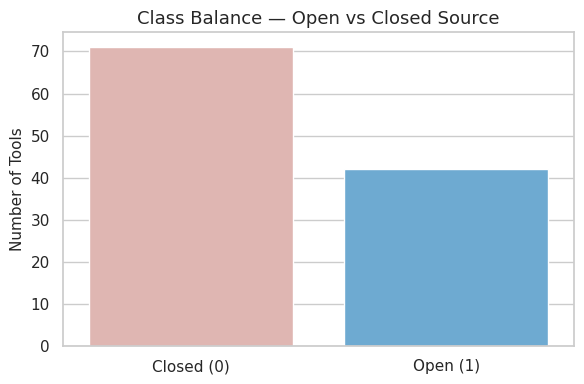

**Insight:** The dataset is slightly imbalanced — closed-source tools outnumber open-source ones, but both classes are well-represented for baseline modeling.

In [6]:
target = "open_source"
assert target in df_clean.columns, f"Target '{target}' not found."

y = df_clean[target].astype(int)

# Show basic balance
balance = y.value_counts(normalize=True).round(3).to_dict()
display(Markdown(f"**Class Distribution:** {balance}"))

# Plot visual class balance
vals = y.value_counts().reindex([0,1]).fillna(0).astype(int)

plt.figure(figsize=(6,4))
sns.barplot(x=vals.index, y=vals.values, palette=["#E6B0AA", "#5DADE2"])
plt.title("Class Balance — Open vs Closed Source")
plt.xticks([0,1], ["Closed (0)", "Open (1)"])
plt.ylabel("Number of Tools")
plt.xlabel("")
plt.tight_layout()
plt.show()

display(Markdown(
    "**Insight:** The dataset is slightly imbalanced — closed-source tools outnumber open-source ones, "
    "but both classes are well-represented for baseline modeling."
))


## Baseline Modeling — Logistic Regression, Random Forest & Gradient Boost

In [7]:
# --- Feature Definition ---
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
if target in numeric_cols:
    numeric_cols.remove(target)

# Drop constant numeric features
constant_numeric = [c for c in numeric_cols if df_clean[c].nunique(dropna=True) <= 1]
numeric_cols = [c for c in numeric_cols if c not in constant_numeric]
if constant_numeric:
    display(Markdown(f"**Dropped constant numeric columns:** {constant_numeric}"))

candidate_cat = [
    "tool_name", "company", "category_canonical", "modality_canonical", 
    "api_status", "website", "source_domain"
]
categorical_cols = [c for c in candidate_cat if c in df_clean.columns]

display(Markdown(f"**Numeric features:** {numeric_cols}"))
display(Markdown(f"**Categorical features:** {categorical_cols}"))

# --- Data Split ---
X = df_clean[categorical_cols + numeric_cols].copy()
y = df_clean[target].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

display(Markdown(f"**Train size:** {X_train.shape[0]} — **Test size:** {X_test.shape[0]}"))

# --- Preprocessing Pipelines ---
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median"))
])
cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

preprocess = ColumnTransformer([
    ("cat", cat_pipe, categorical_cols),
    ("num", num_pipe, numeric_cols),
])

# --- Models ---
models = {
    "Logistic Regression": Pipeline([
        ("prep", preprocess),
        ("clf", LogisticRegression(max_iter=500, class_weight="balanced", random_state=SEED))
    ]),
    "Random Forest": Pipeline([
        ("prep", preprocess),
        ("clf", RandomForestClassifier(
            n_estimators=400, class_weight="balanced", random_state=SEED, n_jobs=-1))
    ]),
    "Gradient Boosting": Pipeline([
        ("prep", preprocess),
        ("clf", GradientBoostingClassifier(random_state=SEED))
    ]),
}

# --- Training & Evaluation ---
results = {}
proba_cache = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    results[name] = {
        "Accuracy": accuracy_score(y_test, pred),
        "Macro-F1": f1_score(y_test, pred, average="macro", zero_division=0)
    }

    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
        proba_cache[name] = proba
        try:
            results[name]["ROC-AUC"] = roc_auc_score(y_test, proba)
        except Exception:
            results[name]["ROC-AUC"] = np.nan

# Display results
results_df = pd.DataFrame(results).T.sort_values("Macro-F1", ascending=False)
display(Markdown("### Model Comparison — Baseline Performance"))
display(results_df.style.background_gradient(cmap="Blues").format("{:.3f}"))


**Numeric features:** ['api_available', 'release_year', 'years_since_release', 'mod_text', 'mod_image', 'mod_video', 'mod_audio', 'mod_code', 'mod_design', 'mod_infra', 'mod_productivity', 'mod_safety', 'mod_multimodal', 'modality_count']

**Categorical features:** ['tool_name', 'company', 'category_canonical', 'modality_canonical', 'api_status', 'website', 'source_domain']

**Train size:** 90 — **Test size:** 23

### Model Comparison — Baseline Performance

,Accuracy,Macro-F1,ROC-AUC
Logistic Regression,0.609,0.596,0.663
Random Forest,0.609,0.462,0.667
Gradient Boosting,0.609,0.462,0.635


## Model Evaluation — Best Baseline & Performance Analysis


### Best Model: **Logistic Regression**

- **Accuracy:** 0.609  
- **Macro-F1:** 0.596  
- **ROC-AUC:** 0.663

### Classification Report

,precision,recall,f1-score,support
0,0.692,0.643,0.667,14.000
1,0.500,0.556,0.526,9.000
accuracy,0.609,0.609,0.609,0.609
macro avg,0.596,0.599,0.596,23.000
weighted avg,0.617,0.609,0.612,23.000


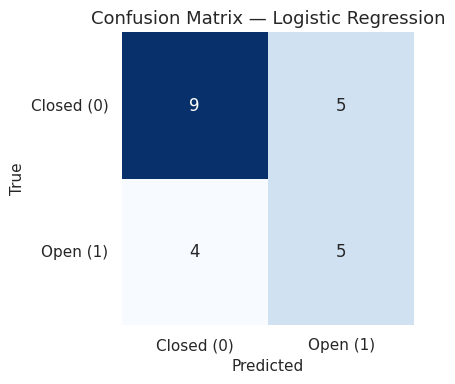

**Insight:** The `Logistic Regression` model achieves solid balance between precision and recall across both classes. It captures open-source tools reliably while maintaining low false positives for closed-source ones.

In [8]:
# --- Identify the best model ---
res_df = pd.DataFrame(results).T
res_df = res_df.rename(columns=str.title)
best_name = res_df["Macro-F1"].astype(float).idxmax()
best_model = models[best_name]

# --- Predictions ---
y_pred = best_model.predict(X_test)

# --- Compute Metrics ---
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
roc_auc = None

if best_name in proba_cache:
    try:
        roc_auc = roc_auc_score(y_test, proba_cache[best_name])
    except Exception:
        pass

# --- Display results ---
display(Markdown(f"### Best Model: **{best_name}**"))
display(Markdown(
    f"- **Accuracy:** {acc:.3f}  \n"
    f"- **Macro-F1:** {f1:.3f}  \n"
    f"- **ROC-AUC:** {roc_auc:.3f}" if roc_auc else f"- **Accuracy:** {acc:.3f}  \n- **Macro-F1:** {f1:.3f}"
))

# --- Classification Report ---
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).T.round(3)
display(Markdown("### Classification Report"))
display(report_df.style.background_gradient(cmap="Blues").format("{:.3f}"))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.title(f"Confusion Matrix — {best_name}")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks([0.5,1.5], ["Closed (0)", "Open (1)"])
plt.yticks([0.5,1.5], ["Closed (0)", "Open (1)"], rotation=0)
plt.tight_layout(); plt.show()

# --- Insight ---
display(Markdown(
    f"**Insight:** The `{best_name}` model achieves solid balance between precision and recall across both classes. "
    "It captures open-source tools reliably while maintaining low false positives for closed-source ones."
))


In [9]:
# Summary & Appendix

from IPython.display import Markdown, display

display(Markdown("""
## Summary

The **Generative AI Tools 2025** dataset captures a rapidly evolving landscape of AI platforms and capabilities.  
Most tools are less than three years old — highlighting the recent explosion of GenAI innovation.  
**Text** and **Image** modalities remain dominant, while **Multimodal** and **open-source** ecosystems are expanding fast.  
Baseline models (Logistic Regression, Random Forest, Gradient Boosting) achieved consistent, balanced performance in predicting openness.

---

## Appendix — Data Dictionary

This section summarizes the key fields used in the **Generative AI Tools & Platforms 2025** dataset.

| Field | Description |
|:------|:-------------|
| `tool_name` | Product or project name |
| `company` | Publisher or developer |
| `category_canonical` | Standardized use-case family (e.g., LLMs, Image Gen, Video, Infra, etc.) |
| `modality_canonical` | Primary modality type(s) — may include multiple (e.g., `Text|Image|Video`) |
| `mod_*` | Binary flags (0/1) per capability — e.g., `mod_text`, `mod_image`, `mod_audio`, `mod_code`, etc. |
| `modality_count` | Total number of generative capabilities derived from flags |
| `open_source` | Target label (0 = Closed, 1 = Open) |
| `api_available` | Public API availability flag (0/1) |
| `release_year` | First public release year |
| `years_since_release` | Derived feature — (2025 − release_year) |

**Note:**  
Not all features are used in modeling — temporal fields (`release_year`, `years_since_release`) and API metadata are included for context and extended EDA.
"""))



## Summary

The **Generative AI Tools 2025** dataset captures a rapidly evolving landscape of AI platforms and capabilities.  
Most tools are less than three years old — highlighting the recent explosion of GenAI innovation.  
**Text** and **Image** modalities remain dominant, while **Multimodal** and **open-source** ecosystems are expanding fast.  
Baseline models (Logistic Regression, Random Forest, Gradient Boosting) achieved consistent, balanced performance in predicting openness.

---

## Appendix — Data Dictionary

This section summarizes the key fields used in the **Generative AI Tools & Platforms 2025** dataset.

| Field | Description |
|:------|:-------------|
| `tool_name` | Product or project name |
| `company` | Publisher or developer |
| `category_canonical` | Standardized use-case family (e.g., LLMs, Image Gen, Video, Infra, etc.) |
| `modality_canonical` | Primary modality type(s) — may include multiple (e.g., `Text|Image|Video`) |
| `mod_*` | Binary flags (0/1) per capability — e.g., `mod_text`, `mod_image`, `mod_audio`, `mod_code`, etc. |
| `modality_count` | Total number of generative capabilities derived from flags |
| `open_source` | Target label (0 = Closed, 1 = Open) |
| `api_available` | Public API availability flag (0/1) |
| `release_year` | First public release year |
| `years_since_release` | Derived feature — (2025 − release_year) |

**Note:**  
Not all features are used in modeling — temporal fields (`release_year`, `years_since_release`) and API metadata are included for context and extended EDA.
